# English to Arabic Translation 

## Imports

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import torch
import random
import re

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.ar import Arabic


import torch
import torch.nn as nn
from torch import optim


from torchtext import data
from torchtext.legacy import data


## Data Processing

In [32]:
df = pd.read_csv("data/arabic_english.txt",delimiter="\t",names=["eng","ar"])
df

,eng,ar
0,Hi.,مرحبًا.
1,Run!,اركض!
2,Help!,النجدة!
3,Jump!,اقفز!
4,Stop!,قف!
...,...,...
24633,rising voices promoting a more linguistically ...,شاركنا تحدي ابداع ميم بلغتك الام تعزيزا للتنوع...
24634,following last year s successful campaign we i...,استكمالا لنجاح حملة العام السابق ندعوكم للمشار...
24635,during last year s challenge we also met langu...,تعرفنا خلال تحدي العام الماضي على ابطال لغويين...
24636,to take part just follow the simple steps outl...,للمشاركة في التحدي اتبع الخطوات الموضحة على ال...


In [33]:
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


### tokenizers

In [34]:
seed=32

spacy_eng = spacy.load("en_core_web_sm")

arab = Arabic()
ar_Tokenizer = Tokenizer(arab.vocab)

def engTokenizer(text):
 return  [word.text for word in spacy_eng.tokenizer(text)] 

def arTokenizer(sentence):
    return  [word.text for word in 
             ar_Tokenizer(re.sub(r"\s+"," ",re.sub(r"[\.\'\"\n+]"," ",sentence)).strip())]

SRC = data.Field(tokenize=engTokenizer,batch_first=False,init_token="<sos>",eos_token="<eos>")
TRG = data.Field(tokenize=arTokenizer,batch_first=False,tokenizer_language="ar",init_token="بداية",eos_token="نهاية")

class TextDataset(data.Dataset):

    def __init__(self, df, src_field, target_field, is_test=False, **kwargs):
        fields = [('eng', src_field), ('ar',target_field)]
        samples = []
        for i, row in df.iterrows():
            eng = row.eng 
            ar = row.ar
            samples.append(data.Example.fromlist([eng, ar], fields))

        super().__init__(samples, fields, **kwargs)
    def __len__(self):
        return len(self.samples)
        
    def __getitem__(self, idx):
        return self.samples[idx]

torchdataset = TextDataset(df,SRC,TRG)

train_data, valid_data = torchdataset.split(split_ratio=0.8, random_state = random.seed(32))

SRC.build_vocab(train_data,min_freq=2)
TRG.build_vocab(train_data,min_freq=2)

print(train_data[1].__dict__)


{'eng': ['I', 'was', 'delayed', 'by', 'a', 'traffic', 'jam', '.'], 'ar': ['أخّرني', 'زحام', 'السير']}


### seting up the device

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print(device)
print(torch.cuda.get_device_name(0))
# full infos
# !nvidia-smi

cuda
NVIDIA GeForce RTX 3060 Ti


## Transformer Class

In [36]:
class Transformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        forward_expansion,
        dropout,
        max_len,
        device,
    ):
        super(Transformer, self).__init__()
        self.src_embeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.src_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.trg_embeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.trg_positional_embeddings= nn.Embedding(max_len,embedding_size)
        self.device = device
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
            forward_expansion,
            dropout,
        )

        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(dropout)
        self.src_pad_idx = src_pad_idx
    
    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask

    def forward(self,src,trg):
        src_seq_length, S = src.shape
        trg_seq_length, S = trg.shape
        #adding zeros is an easy way
        src_positions = (
            torch.arange(0, src_seq_length).unsqueeze(1).expand(src_seq_length, S).to(self.device)
        )
        
        
        trg_positions = (
            torch.arange(0, trg_seq_length).unsqueeze(1).expand(trg_seq_length, S).to(self.device)
        )

        embed_src  = self.dropout(
                ( self.src_embeddings(src) + self.src_positional_embeddings(src_positions) )
            )

        embed_trg = self.dropout(
                ( self.trg_embeddings(trg) + self.trg_positional_embeddings(trg_positions) )
            )
        
        src_padding_mask = self.make_src_mask(src)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)
        
        
        out = self.transformer(embed_src,embed_trg, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)

        return out

## Model and Parameters 

In [37]:
BATCH_SIZE = 16

train_iter, valid_iter = data.BucketIterator.splits(
    (train_data,valid_data), 
    batch_size = BATCH_SIZE,
    sort=None,
    sort_within_batch=False,
    sort_key=lambda x: len(x.eng),
    device = device,
    shuffle=True
)

In [38]:
load_model = False
save_model = True

num_epochs = 40
learning_rate = 0.0003

num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3

max_len= 230
dropout = 0.10
embedding_size= 256
src_pad_idx = SRC.vocab.stoi["<pad>"]
forward_expansion = 4
step = 0


src_vocab_size  = len(SRC.vocab)
print("Size of english vocabulary:",src_vocab_size)

trg_vocab_size =len(TRG.vocab)
print("Size of arabic vocabulary:",trg_vocab_size)


model = Transformer(        
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    forward_expansion,
    dropout,
    max_len,
    device,
).to(device)

Size of english vocabulary: 12812
Size of arabic vocabulary: 22067


In [39]:
print(model)

Transformer(
  (src_embeddings): Embedding(12812, 256)
  (src_positional_embeddings): Embedding(230, 256)
  (trg_embeddings): Embedding(22067, 256)
  (trg_positional_embeddings): Embedding(230, 256)
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=4, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=4, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
        (1): TransformerEncoderLayer(
          (self_attn

## Training

In [40]:
torch.cuda.empty_cache()

In [41]:
loss_track = []
loss_validation_track= []


optimizer = optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = SRC.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index = pad_idx)
for epoch in range(num_epochs):
    stepLoss=[]
    model.train()
    for batch  in train_iter:
        input_data = batch.eng.to(device)
        target = batch.ar.to(device)

        output = model(input_data,target[:-1])
        optimizer.zero_grad()
        
        output = output.reshape(-1,trg_vocab_size)
        target = target[1:].reshape(-1)

        loss = criterion(output,target)
        loss.backward()

        optimizer.step()
        stepLoss.append(loss.item())

    loss_track.append(np.mean(stepLoss))
    print(" Epoch {} | Train Cross Entropy Loss: ".format(epoch),np.mean(stepLoss))
    with torch.no_grad():    
      stepValidLoss=[]
      model.eval() # the evaluation mode for the model (doesn't apply dropout and batchNorm)
      for i,batch  in enumerate(valid_iter):
            input_sentence = batch.eng.to(device)
            target = batch.ar.to(device)
            optimizer.zero_grad()
            output = model(input_sentence,target[:-1])
            output = output.reshape(-1,trg_vocab_size)
            target = target[1:].reshape(-1)
            loss = criterion(output,target)
                  
            stepValidLoss.append(loss.item())
    
    loss_validation_track.append(np.mean(stepValidLoss))
    print(" Epoch {} | Validation Cross Entropy Loss: ".format(epoch),np.mean(stepValidLoss))   

 Epoch 0 | Train Cross Entropy Loss:  7.372471018271013
 Epoch 0 | Validation Cross Entropy Loss:  5.894426894652379
 Epoch 1 | Train Cross Entropy Loss:  6.816339350753016
 Epoch 1 | Validation Cross Entropy Loss:  5.581868270000854
 Epoch 2 | Train Cross Entropy Loss:  6.407038116222852
 Epoch 2 | Validation Cross Entropy Loss:  5.365652969905308
 Epoch 3 | Train Cross Entropy Loss:  5.956349026073109
 Epoch 3 | Validation Cross Entropy Loss:  5.176230578453509
 Epoch 4 | Train Cross Entropy Loss:  5.484562020410191
 Epoch 4 | Validation Cross Entropy Loss:  5.027487570589239
 Epoch 5 | Train Cross Entropy Loss:  5.019678009407861
 Epoch 5 | Validation Cross Entropy Loss:  4.924361591215257
 Epoch 6 | Train Cross Entropy Loss:  4.556912215499135
 Epoch 6 | Validation Cross Entropy Loss:  4.929872166800808
 Epoch 7 | Train Cross Entropy Loss:  4.120508965153198
 Epoch 7 | Validation Cross Entropy Loss:  4.894298438127938
 Epoch 8 | Train Cross Entropy Loss:  3.719940510856641
 Epoch 8

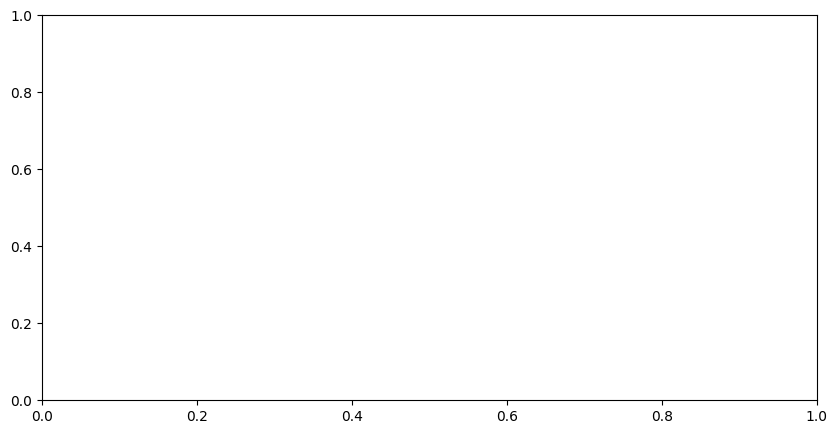

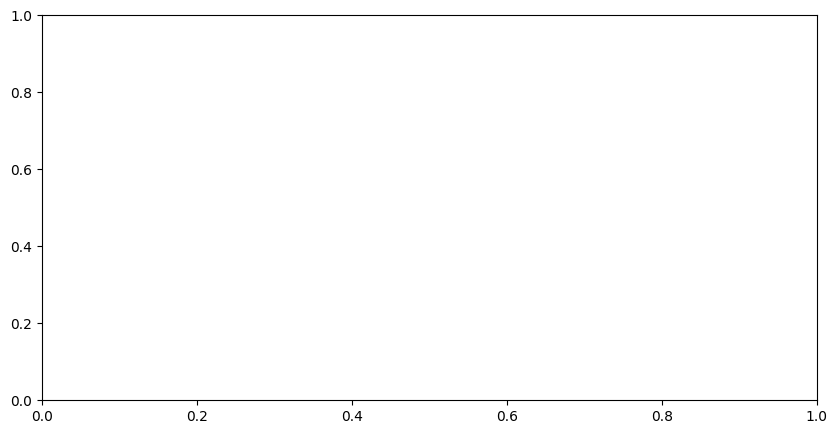

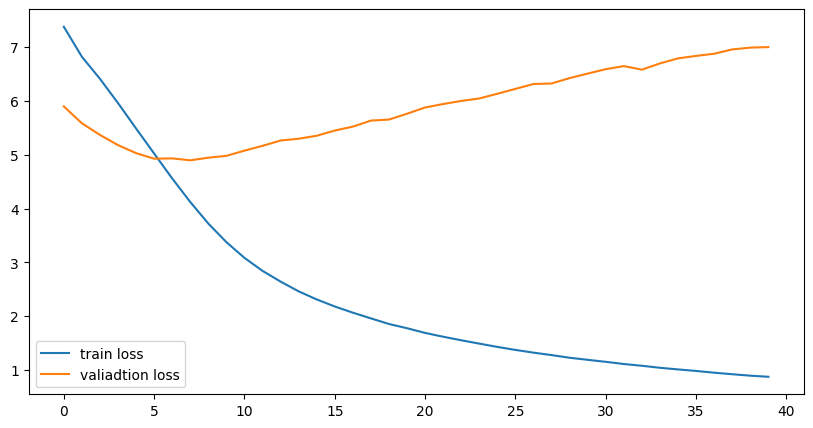

In [44]:
#the train loss after 50 epoch
plt.figure(figsize=(10,5))
plt.plot(range(40),loss_track,label="train loss")
plt.plot(range(40),loss_validation_track,label="valiadtion loss")
plt.legend()
plt.show()

## Translation

In [ ]:
def translate_sentence(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["بداية"]

    for _ in range(60):
        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        trg_tensor = torch.LongTensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,trg_tensor)
        
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue 
        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])
        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "نهاية":
            break
    return " ".join([word for word in trg if word != "<unk>"][1:-1])


In [ ]:
translate_sentence(model,"I'm at home" ,SRC,TRG,engTokenizer)

'في محاولة عدت في البيت'

In [ ]:
translate_sentence(model,"I'm alone" ,SRC,TRG,engTokenizer)

'أنا'

In [ ]:
translate_sentence(model,"I'm sad" ,SRC,TRG,engTokenizer)

'حزين حزين حزين حزين'

In [ ]:
translate_sentence(model,"are you good" ,SRC,TRG,engTokenizer)

'هل'